In [1]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image
from controlnet_aux import MidasDetector,OpenposeDetector,HEDdetector
# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5"
# )

# speed up diffusion process with faster scheduler and memory optimization

midas = MidasDetector.from_pretrained("lllyasviel/Annotators")
openpose = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
hed = HEDdetector.from_pretrained("lllyasviel/Annotators")

generator = torch.manual_seed(100)
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
controlnet1= ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet1
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
from controlnet_naive import ControlNetModel
statedictpipe=pipe.controlnet.state_dict()
new_unet=ControlNetModel()
new_unet.load_state_dict(statedictpipe)
pipe.controlnet=new_unet
edge_image=load_image('/media/labuser/sdb/Controlpromptediting/diffscaler_multimodal/spider5.jpg').convert("RGB")
image=midas(edge_image)
image=Image.fromarray(np.array(image))
image.save('spider_depth.png')
# image = cv2.Canny(edge_image, 100,200)
# image = image[:, :, None]
# image = np.concatenate([image, image, image], axis=2)
# image = Image.fromarray(image)
# image.resize((512,512)).save('canny.png')
pipe.to("cuda")


/home/labuser/anaconda3/envs/diffusers_freeu/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.22.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "controlnet_naive",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
# from controlnet_naive import ControlNetModel
# statedictpipe=pipe.controlnet.state_dict()
# new_unet=ControlNetModel()

In [3]:
# image
# edge_image=load_image('/media/labuser/sdb/Controlpromptediting/diffscaler_multimodal/Cflower2.jpg').convert("RGB")
# image=midas(edge_image)
# image=Image.fromarray(np.array(image))
# # image.save('spider_depth.png')
# image1=image.resize((512,512))
# image1.save('flower_depth.png')

In [4]:
# new_unet.load_state_dict(statedictpipe)
# pipe.unet=new_unet

In [5]:
import ptp_utils_naive_control as ptp_utils
def run_and_display(pipe,prompts, negative_prompts, latent=None, run_baseline=False, generator=None,  control=None , results_dir='results'):

    images, x_t, all_list_encoder= ptp_utils.text2image_ldm_stable(pipe, prompts, negative_prompts, latent=latent, num_inference_steps=50, guidance_scale=7.5, generator=generator,control=control, low_resource=False)

    # ptp_utils.view_images(images,results_dir=results_dir)
    return images, x_t, all_list_encoder

In [6]:
prompts=["An aesthetic flower in a  garden, high quality"]
negative_prompts=["Bad quality, bad anatomy"]

/media/labuser/sdb/Controlpromptediting/diffscaler_multimodal/ptp_utils_naive_control.py:189: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/50 [00:00<?, ?it/s]

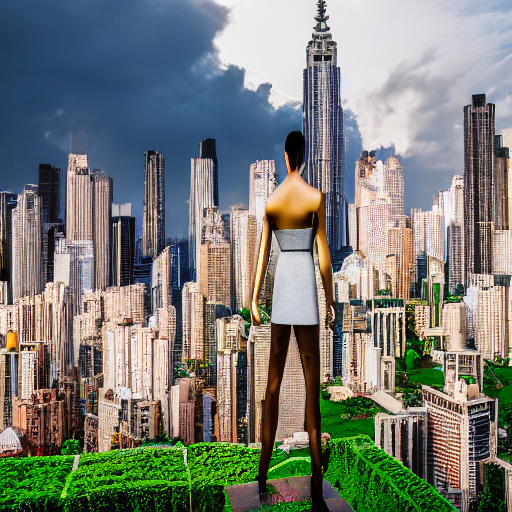

In [7]:
pipe = pipe.to("cuda")
g_cpu = torch.Generator().manual_seed(100)
latent = torch.randn(
                (1, 4,512 // 8, 512 // 8),
                generator=g_cpu,
            )
a,b,c=run_and_display(pipe,prompts, negative_prompts, latent=latent, run_baseline=False, generator=None, control=image, results_dir='results')
ptp_utils.view_images(a)

In [8]:
# a=Image.fromarray(a)
# a.save('flower_gen.png')
# stop

50


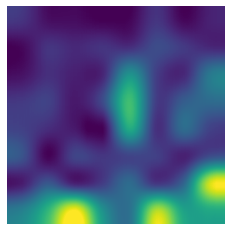

In [9]:
import os

# import nump
from PIL import Image
import matplotlib.pyplot as plt

def save_image(imagea, loc):
    # if image.shape[1]>=64:
        imagea=imagea-imagea.min()
        imagea=imagea/imagea.max()
        imagea = imagea[0].cpu().cpu().numpy()
        # image=(image-np.min(image))(np.max(image)-np.min(image))
        imagea = (imagea * 255).astype(np.uint8)
        imagea=Image.fromarray(imagea)
        imagea=imagea.resize((256,256))
        image_array = np.array(imagea)

        # Create a heatmap from the array
        plt.imshow(image_array, cmap='viridis')

        # Remove axes and save the heatmap
        plt.axis('off')
        plt.savefig(loc, bbox_inches='tight', pad_inches=0)
        return imagea
    # return None
    
print(len(c))
count=0
for list1 in c:
    count=count+1
    # print(list1)
    for list2 in list1:
        # print(list2.shape,count)
        # print(list2)
        if os.path.exists('spider_depth1')==False:
             os.makedirs('spider_depth1')
        if image is not None:
            dirname=len(os.listdir('/media/labuser/sdb/Controlpromptediting/diffscaler_multimodal/spider_depth1'))
        loc = os.path.join('/media/labuser/sdb/Controlpromptediting/diffscaler_multimodal/spider_depth1', str(dirname)+'.png')
        image=save_image(list2,loc)


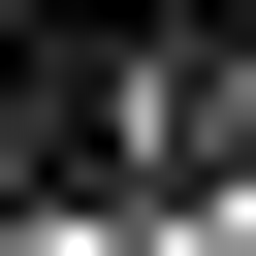

In [10]:
image